<a href="https://colab.research.google.com/github/JulianEspinosaUrresti/ProyectoI-MIAA-2025/blob/main/Taller_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Carga de paquetes**

In [70]:
!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error

## **2. Carga de datos**

In [71]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [72]:
data.describe()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
count,222.000000,222.000000,222.000000,222.000000
mean,12.601883,9160.852009,1290.681131,5500.277973
std,2.808235,1295.492800,181.948810,389.227213
min,8.140713,6923.604000,857.491000,4596.805000
25%,10.396078,7971.103000,1152.874750,5308.814750
50%,11.925036,9139.064500,1270.201000,5533.044500
75%,14.087588,10458.510250,1398.899250,5752.608500
max,20.946380,11037.199000,1834.507000,6395.575000


## **3. ACF y PACF**

Como la serie “Ocupados” contiene 222 observaciones se calculó el ACF hasta 40 rezagos, lo cual corresponde aproximadamente al 18%.

In [73]:
acf(data['Ocupados'],40)

array([1.        , 0.97855484, 0.96290943, 0.94999592, 0.93767278,
       0.92828634, 0.91803512, 0.90827078, 0.89628125, 0.88592368,
       0.8772359 , 0.8728291 , 0.86780346, 0.84936325, 0.83206921,
       0.81773834, 0.80588679, 0.79695724, 0.78708534, 0.77639894,
       0.76345987, 0.75177965, 0.74296472, 0.73663393, 0.73128083,
       0.71333785, 0.69520217, 0.68008434, 0.66685076, 0.65659735,
       0.64390143, 0.63170587, 0.6184013 , 0.60541159, 0.59596135,
       0.58936238, 0.5824738 , 0.56326155, 0.54546119, 0.53051481,
       0.51728811])

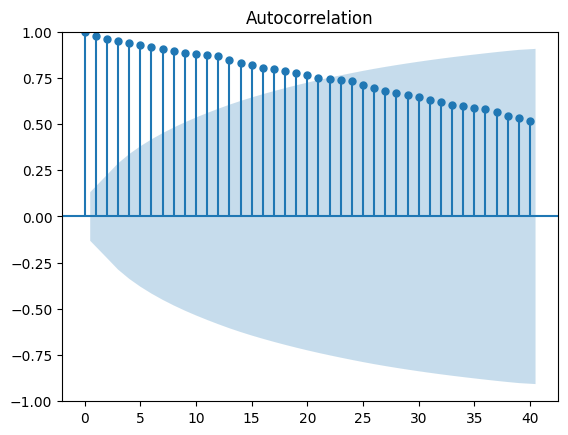

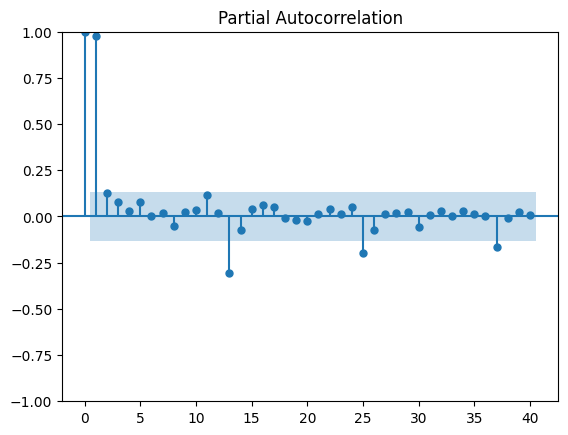

In [74]:
plot_acf(data['Ocupados'],lags=40);
plot_pacf(data['Ocupados'],lags=40);

El ACF de la serie “Ocupados” presenta autocorrelaciones altas en los primeros rezagos y un decaimiento muy lento a lo largo de los 40 rezagos. Esto nos indica que la serie es no estacionaria, por lo que requiere ser diferenciada para lograr estacionariedad (modelo ARIMA).

El PACF muestra un pico pronunciado en el rezago 1 y un segundo en el rezago 2, seguido de valores no significativos, lo cual indica un proceso integrado de primer orden.

## **4. Modelo Arima con auto_arima**

In [75]:
model = auto_arima(data["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1451.595
Date:                Mon, 17 Nov 2025   AIC                           2911.190
Time:                        16:16:36   BIC                           2924.782
Sample:                    01-01-2001   HQIC                          2916.678
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8551      2.485      3.965      0.000       4.984      14.726
ar.L1          0.4419      0.101      4.357      0.000       0.243       0.641
ma.L1         -0.8618      0.053    -16.414      0.000      -0.965      -0.759
sigma2      2.948e+04   2480.399     11.885      0.000    2.46e+04    3.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                57.86
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.99
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Utilizando auto_arima se determinó que el modelo óptimo para la serie “Ocupados” es ARIMA(1,1,1).

Para evaluar el desempeño del modelo ARIMA obtenido en auto_arima utilizamos el RMSE fuera de muestra, comparando el pronóstico con los últimos 6 valores reales:

In [76]:
h = 6

train = data["Ocupados"].iloc[:-h]
test  = data["Ocupados"].iloc[-h:]

model_oos = auto_arima(train, max_p=10, max_q=10, information_criterion="aic")

forecast = model_oos.predict(n_periods=h)

rmse_oos = np.sqrt(mean_squared_error(test, forecast))
print("RMSE fuera de muestra (auto_arima):", rmse_oos)

RMSE fuera de muestra (auto_arima): 346.2353678613829


Ajustamos un modelo ARIMA con los diferentes criterios de selección (AIC, AICC, BIC, HQIC y OOB) sobre los datos de entrenamiento y calculamos el RMSE fuera de muestra para cada uno:

In [77]:
h = 6

train = data["Ocupados"].iloc[:-h]
test  = data["Ocupados"].iloc[-h:]

criterios = ["aic", "aicc", "bic", "hqic", "oob"]
resultados = []

for c in criterios:
    print(f"\n=== Criterio: {c} ===")

    model = auto_arima(
        train,
        max_p=10,
        max_q=10,
        seasonal=False,
        information_criterion=c,
        stepwise=True,
        suppress_warnings=True)

    forecast = model.predict(n_periods=h)
    rmse_oos = np.sqrt(mean_squared_error(test, forecast))

    res_sm = model.arima_res_

    resultados.append({
        "criterio": c,
        "orden_ARIMA": model.order,
        "AIC":  res_sm.aic,
        "BIC":  res_sm.bic,
        "HQIC": res_sm.hqic,
        "RMSE_oos": rmse_oos
    })

tabla_modelos = pd.DataFrame(resultados)
print("\nTABLA COMPARATIVA DE MODELOS:\n")
print(tabla_modelos)


=== Criterio: aic ===

=== Criterio: aicc ===

=== Criterio: bic ===

=== Criterio: hqic ===

=== Criterio: oob ===


/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '



TABLA COMPARATIVA DE MODELOS:

  criterio orden_ARIMA          AIC          BIC         HQIC    RMSE_oos
0      aic   (1, 1, 1)  2825.418389  2838.900941  2830.865963  346.235368
1     aicc   (1, 1, 1)  2825.418389  2838.900941  2830.865963  346.235368
2      bic   (1, 1, 1)  2825.418389  2838.900941  2830.865963  346.235368
3     hqic   (1, 1, 1)  2825.418389  2838.900941  2830.865963  346.235368
4      oob   (1, 1, 1)  2825.418389  2838.900941  2830.865963  346.235368


## **4. Residuales**


In [78]:
model.resid()

,0
mes,
2001-01-01,6905.151379
2001-02-01,157.648305
2001-03-01,-40.566599
2001-04-01,26.635836
2001-05-01,20.317884
...,...
2018-08-01,-183.469651
2018-09-01,148.142550
2018-10-01,-93.284376


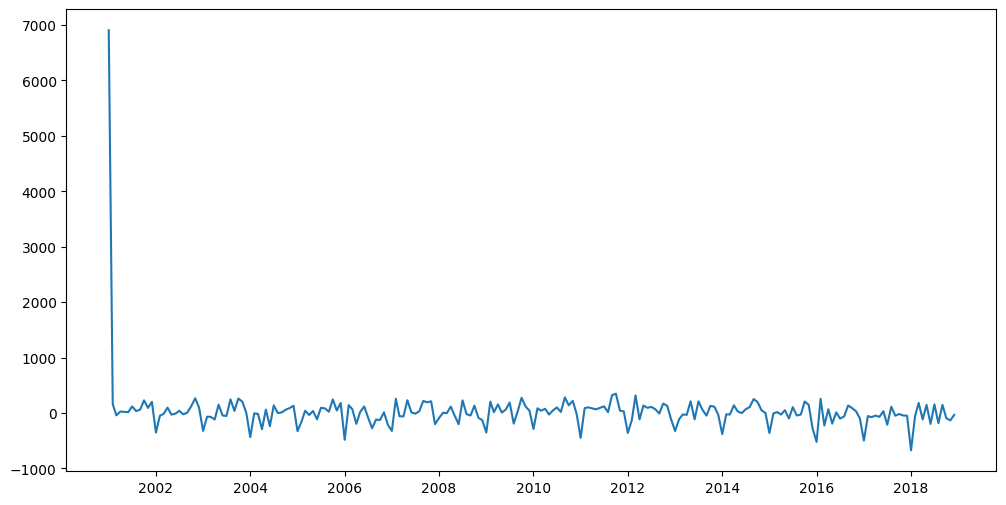

In [79]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid(),label="Residuales")

El primer residual es mucho más grande que el resto de los residuales. Es decir, que está fuera de patrón.

Por lo anterior, se determina no darle importancia dentro de las estimaciones y calcular los residuales sin el primero:

In [80]:
res = model.resid()[1:]

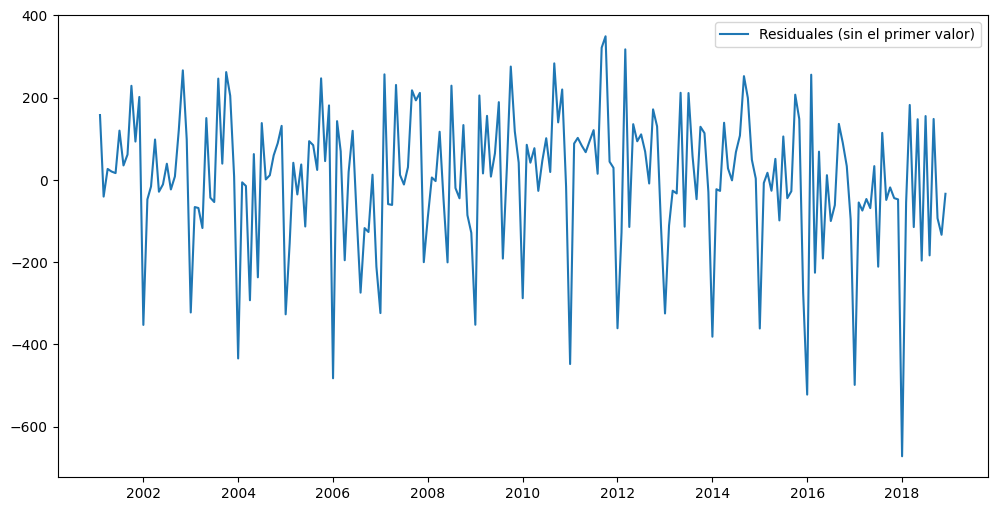

In [81]:
fig = plt.figure(figsize=(12, 6))
plt.plot(res, label="Residuales (sin el primer valor)")
plt.legend()
plt.show()

## **Pronóstico del ARIMA(1,1,1) obtenido en el auto_arima:**

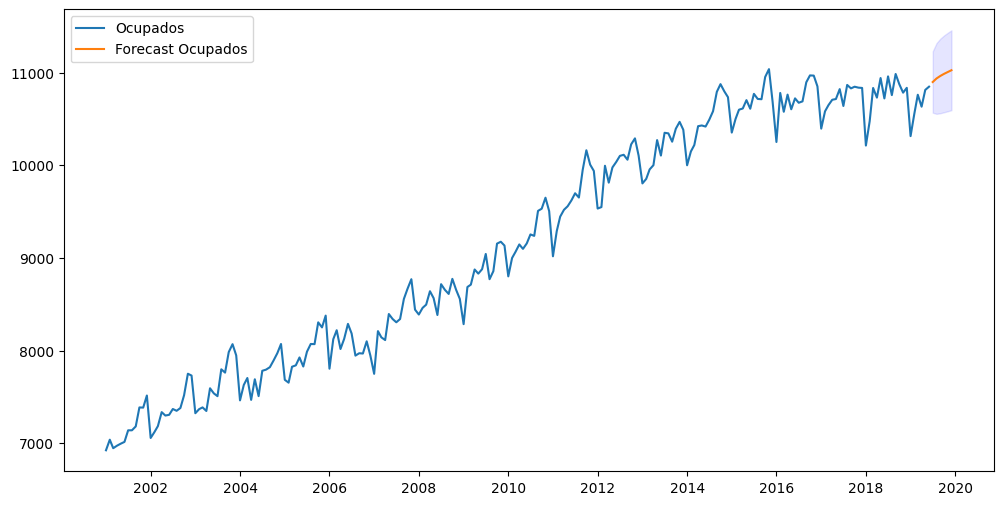

In [82]:
h=6

y_forec, conf_int = model.predict(h, return_conf_int=True, alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec, conf_int[:,0], conf_int[:,1]]),
                     columns=['Point_forecast', 'lower_95', 'upper_95'])

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=h+1, freq='MS')[1:]

fig = plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Ocupados"], label="Ocupados")
plt.plot(future_dates, preds["Point_forecast"], label="Forecast Ocupados")
plt.fill_between(future_dates, preds["lower_95"], preds["upper_95"],
                 color='blue', alpha=0.1)
plt.legend()
plt.show()

## **5. Modelo ARIMA sin auto_arima**

In [83]:
model = ARIMA(order=(1,1,1))
results = model.fit( data["Ocupados"])
results.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1451.595
Date:                Mon, 17 Nov 2025   AIC                           2911.190
Time:                        16:16:57   BIC                           2924.782
Sample:                    01-01-2001   HQIC                          2916.678
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8551      2.485      3.965      0.000       4.984      14.726
ar.L1          0.4419      0.101      4.357      0.000       0.243       0.641
ma.L1         -0.8618      0.053    -16.414      0.000      -0.965      -0.759
sigma2      2.948e+04   2480.399     11.885      0.000    2.46e+04    3.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                57.86
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.99
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
model = ARIMA(order=(1,1,1))
results = model.fit(train)

forecast = results.predict(n_periods=h)

rmse_oos = np.sqrt(mean_squared_error(test, forecast))
print("RMSE fuera de muestra:", rmse_oos)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE fuera de muestra: 346.2353678613829


## **6. Intervalos de confianza usando boostrap**


In [85]:
h= 6
res = results.resid()

my_samples = []
for _ in range(1000):

    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0)

fore = results.predict(h,return_conf_int=False)

preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

preds

,Point_forecast,lower_95,upper_95
0,10898.222667,10464.163865,11173.753291
1,10936.404581,10054.716760,11478.245910
2,10963.629505,9647.882881,11781.001457
3,10985.982584,9236.177159,12079.078710
4,11006.169479,8822.305252,12365.576310
5,11025.393216,8407.470187,12668.924326


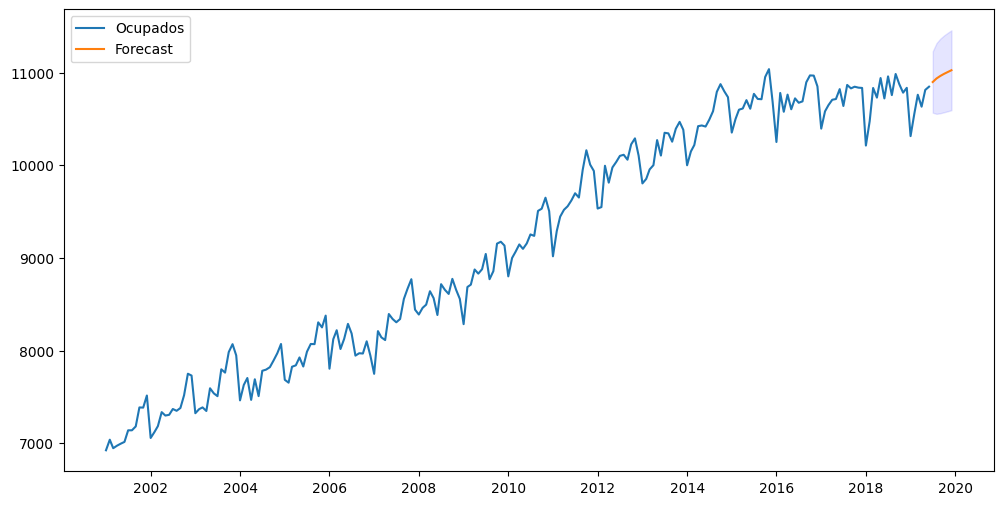

In [86]:
h = 6

y_forec, conf_int = model.predict(h, return_conf_int=True)

preds = pd.DataFrame(
    np.column_stack([y_forec, conf_int[:,0], conf_int[:,1]]),
    columns=['Point_forecast','lower_95','upper_95'])

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=h+1, freq='MS')[1:]

fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data["Ocupados"], label="Ocupados")
plt.plot(future_dates, preds["Point_forecast"], label="Forecast")
plt.fill_between(future_dates, preds["lower_95"], preds["upper_95"], color='blue', alpha=0.1)
plt.legend()
plt.show()

## **7. Validación de Estabilidad e Invertibilidad**


In [87]:
ar_roots = model.arroots()
print("Raíces AR:", ar_roots)

mod_roots = np.abs(ar_roots)
print("Módulo de las raíces:", mod_roots)

if np.all(mod_roots > 1):
    print("El componente AR es estable (todas las raíces están fuera del círculo unitario).")
else:
    print("El componente AR NO es estable (alguna raíz está dentro o sobre el círculo unitario).")

Raíces AR: [2.24904382]
Módulo de las raíces: [2.24904382]
El componente AR es estable (todas las raíces están fuera del círculo unitario).


In [88]:
ma_roots = model.maroots()
print("Raíces MA:", ma_roots)

mod_ma_roots = np.abs(ma_roots)
print("Módulo de las raíces MA:", mod_ma_roots)

if np.all(mod_ma_roots > 1):
    print("El componente MA es invertible (todas las raíces están fuera del círculo unitario).")
else:
    print("El componente MA NO es invertible (alguna raíz está dentro o sobre el círculo unitario).")

Raíces MA: [1.14843704]
Módulo de las raíces MA: [1.14843704]
El componente MA es invertible (todas las raíces están fuera del círculo unitario).
